In [1]:
from os import path
import sys
sys.path.append(path.abspath('../sed'))

In [3]:
import json
import pandas as pd;
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import category_encoders as ce

import lightgbm
import xgboost

import optuna
import hyperopt
import joblib

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, OneHotEncoder,\
OrdinalEncoder, QuantileTransformer, FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, BaseCrossValidator, cross_validate, cross_val_score, train_test_split, \
                                    ShuffleSplit, GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression, LassoLarsCV, LassoCV, MultiTaskElasticNetCV, Lasso, \
RidgeCV, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, RFECV, SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector as selector
from sklearn.decomposition import PCA
from sklearn import set_config


from lightgbm.sklearn import LGBMRegressor
from collections import defaultdict
from joblib import dump, load
from model import *

from matplotlib.axes._axes import _log as matplotlib_axes_logger

matplotlib_axes_logger.setLevel('ERROR')


# set_config(display='diagram')
%matplotlib inline
sns.set()
import warnings
warnings.filterwarnings('ignore')

# Loading Datasets

In [4]:
df = load_dataset("../sed/data/Seattle_example/Seattle_all_Energy_Consumption_cleaned.csv")
pop = load_dataset('../sed/data/Seattle_example/population_by_zip_2010.csv')
gdp = load_dataset("../sed/data/Seattle_example/GDP.csv")
lat_lon = load_dataset('../sed/data/Seattle_example/us-zip-code-latitude-and-longitude.csv')

In [5]:
pop.head()

,population,minimum_age,maximum_age,gender,zipcode,geo_id
0,50,30.0,34.0,female,61747,8600000US61747
1,5,85.0,NaN,male,64120,8600000US64120
2,1389,30.0,34.0,male,95117,8600000US95117
3,231,60.0,61.0,female,74074,8600000US74074
4,56,0.0,4.0,female,58042,8600000US58042


In [6]:
gdp.head()

,ZipCode,MeanHousehold,MedianHousehold,MeanPerCapita,High Income Households,MedianHousehold0_25,MedianHousehold25_44,MedianHousehold45_64,MedianHousehold65_
0,98006,135836.0,180163.0,64946.0,28.90%,NaN,153906.0,148475.0,87335.0
1,98011,95896.0,111105.0,45384.0,11.80%,31342.0,108563.0,110145.0,58810.0
2,98012,101652.0,118189.0,43828.0,12.10%,54837.0,114554.0,110028.0,62385.0
3,98013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,98020,91813.0,127523.0,55699.0,18.50%,43077.0,94336.0,139933.0,62182.0


In [7]:
df.head()

,RID,BuildingID,DataYear,BuildingType,City,State,ZipCode,YearBuilt,PropertyGFATotal,LargestPropertyUseType,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
0,0,1,2015,NonResidential,Seattle,WA,98101,1927,88434,NaN,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,3686160.0,1272388.0
1,1,2,2015,NonResidential,Seattle,WA,98101,1996,103566,NaN,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,3905411.0,4448985.0
2,2,3,2015,NonResidential,Seattle,WA,98101,1969,961990,NaN,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,49762435.0,3709900.0
3,3,8,2015,NonResidential,Seattle,WA,98121,1980,119890,NaN,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,6066245.0,8763105.0
4,4,9,2015,Specialty,Seattle,WA,98101,1999,97288,NaN,135.7,146.9,313.5,321.6,12051984.0,13045258.0,0.0,7271004.0,4781283.0


In [8]:
lat_lon.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,71937,Cove,AR,34.398483,-94.39398,-6,1,"34.398483, -94.39398"
1,72044,Edgemont,AR,35.624351,-92.16056,-6,1,"35.624351, -92.16056"
2,56171,Sherburn,MN,43.660847,-94.74357,-6,1,"43.660847, -94.74357"
3,49430,Lamont,MI,43.010337,-85.89754,-5,1,"43.010337, -85.89754"
4,52585,Richland,IA,41.194129,-91.98027,-6,1,"41.194129, -91.98027"


# EDA

## Visualize variables correlations

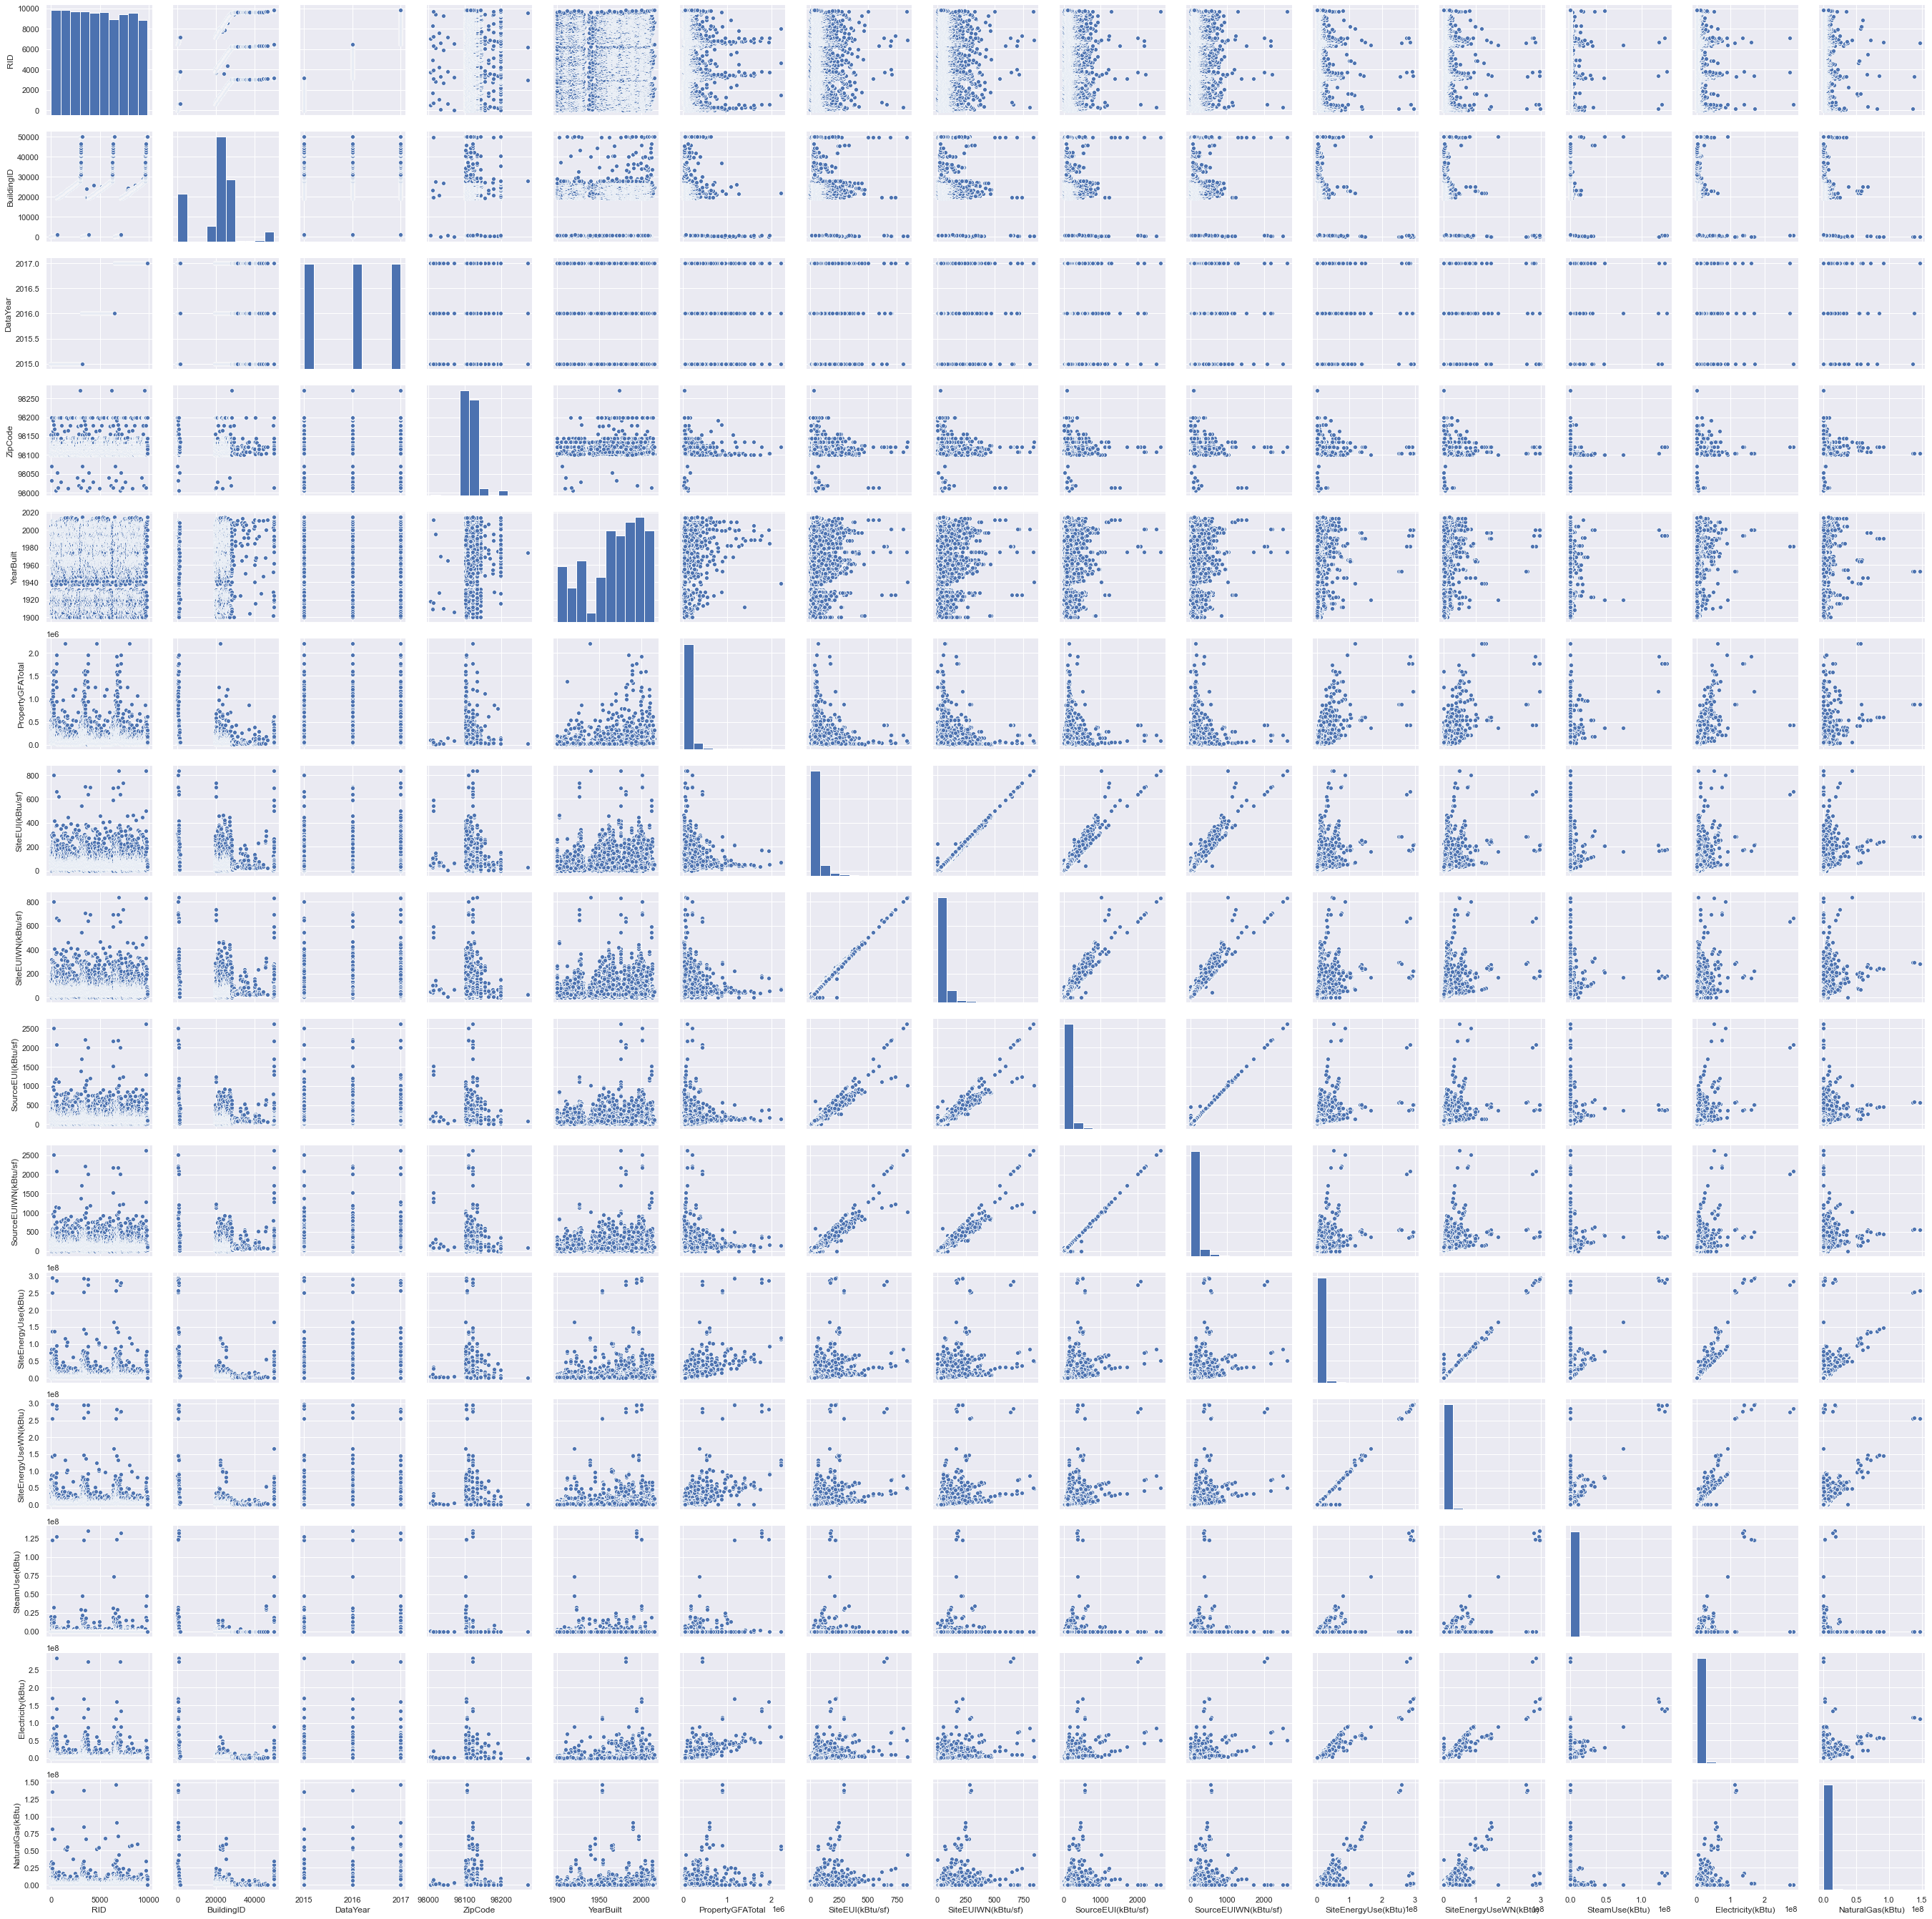

In [9]:
sns.pairplot(df)

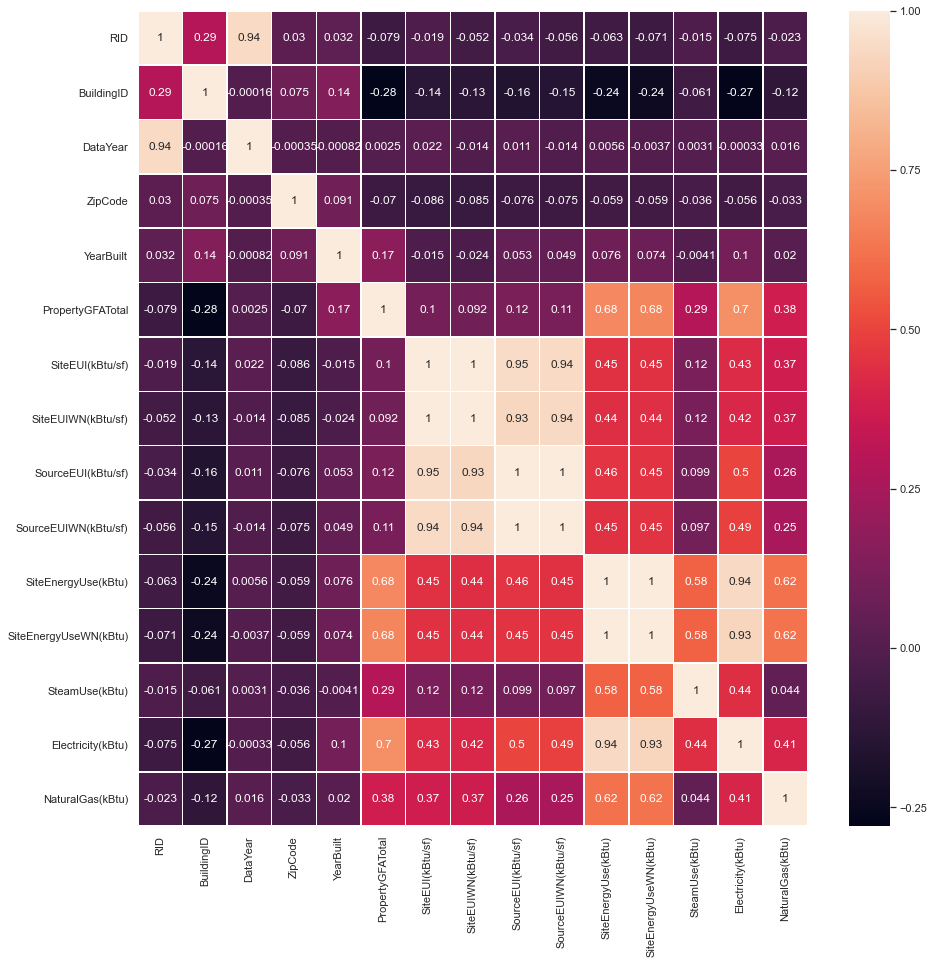

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, ax=ax, linewidths=.5);

## Check outliers and missing data

In [11]:
# count non-zero values
df.astype(bool).sum()

RID                       9434
BuildingID                9435
DataYear                  9435
BuildingType              9435
City                      9435
State                     9435
ZipCode                   9435
YearBuilt                 9435
PropertyGFATotal          9435
LargestPropertyUseType    9435
SiteEUI(kBtu/sf)          9407
SiteEUIWN(kBtu/sf)        9386
SourceEUI(kBtu/sf)        9402
SourceEUIWN(kBtu/sf)      9381
SiteEnergyUse(kBtu)       9407
SiteEnergyUseWN(kBtu)     9386
SteamUse(kBtu)             368
Electricity(kBtu)         9411
NaturalGas(kBtu)          5887
dtype: int64

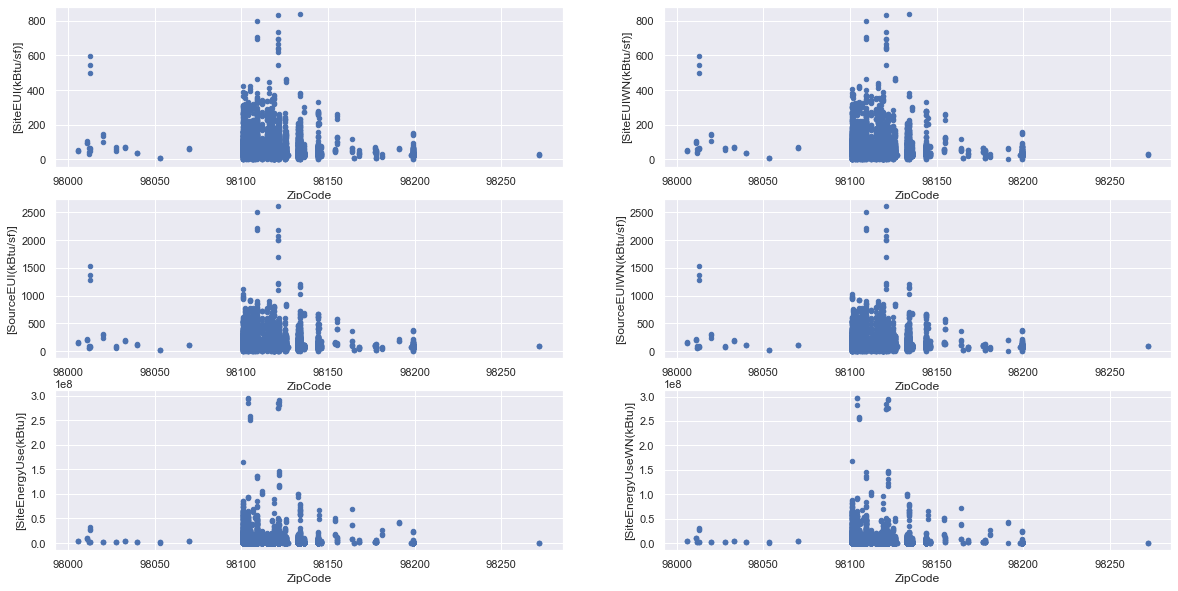

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
df.plot.scatter(x='ZipCode', y=['SiteEUI(kBtu/sf)'], ax=axes[0, 0])
df.plot.scatter(x='ZipCode', y=['SiteEUIWN(kBtu/sf)'], ax=axes[0, 1])
df.plot.scatter(x='ZipCode', y=['SourceEUI(kBtu/sf)'], ax=axes[1, 0])
df.plot.scatter(x='ZipCode', y=['SourceEUIWN(kBtu/sf)'], ax=axes[1, 1])
df.plot.scatter(x='ZipCode', y=['SiteEnergyUse(kBtu)'], ax=axes[2, 0])
df.plot.scatter(x='ZipCode', y=['SiteEnergyUseWN(kBtu)'], ax=axes[2, 1]);

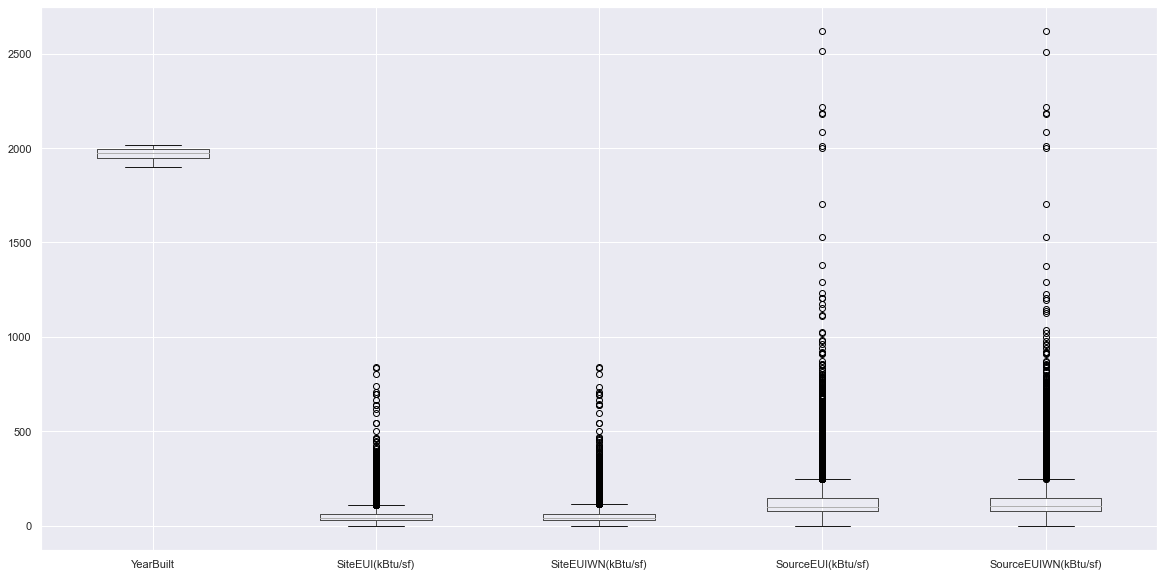

In [13]:
col = ['YearBuilt',
        'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']
df.boxplot(column=col, figsize=(20, 10));

<Figure size 1440x360 with 0 Axes>

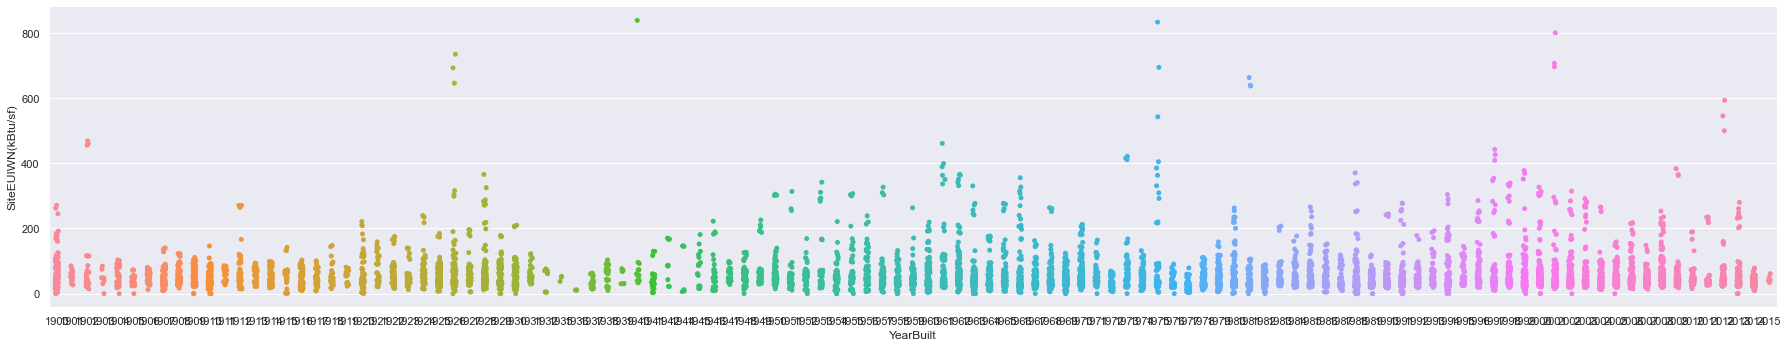

In [14]:
# YearBuilt vs SiteEUIWN
plt.figure(figsize=(20, 5))
sns.catplot(data=df, y='SiteEUIWN(kBtu/sf)', x='YearBuilt', height=5, aspect=5);

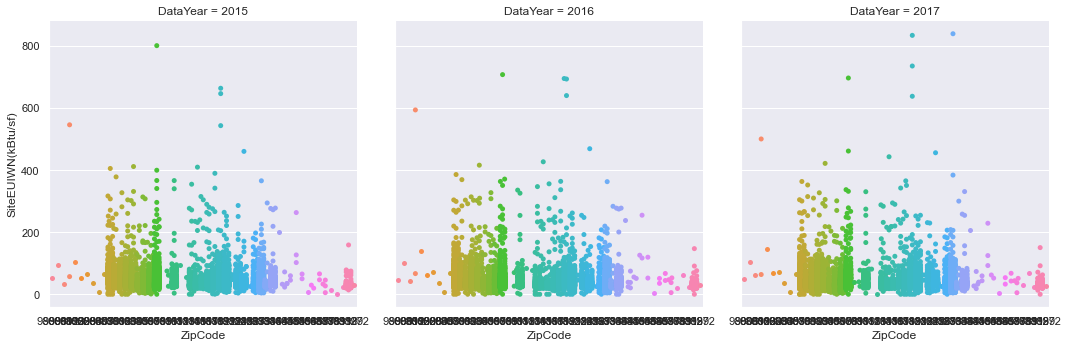

In [15]:
sns.catplot(x='ZipCode', y='SiteEUIWN(kBtu/sf)', data=df, col='DataYear', kind='swarm');

# Data Preprocessing

## population

In [16]:
# reduce size of dataset for example purpose
zipcode_begin = 98000
zipcode_end = 98275
pop = pop[(zipcode_begin <= pop.zipcode) & (pop.zipcode <= zipcode_end)]

In [17]:
drop_cols=['minimum_age', 'maximum_age', 'geo_id']
pop = preprocess_demographic_data(pop, drop_cols=drop_cols, 
                                  pivot_idx='zipcode', pivot_col='gender', aggfunc='sum')
pop.head()

gender,female,male
zipcode,,
98001,31728,32094
98002,32166,31128
98003,45616,42686
98004,28104,27788
98005,17568,17860


## GDP

In [18]:
gdp.rename(columns={'High Income Households': 'HighIncomeHousehold'}, inplace=True)
gdp.HighIncomeHousehold = gdp.HighIncomeHousehold.str.rstrip('%').astype(float)/100.

In [19]:
# filling nan with mean value
gdp.fillna(value=round(gdp.mean()), inplace=True)
gdp.isna().any()

ZipCode                 False
MeanHousehold           False
MedianHousehold         False
MeanPerCapita           False
HighIncomeHousehold     False
MedianHousehold0_25     False
MedianHousehold25_44    False
MedianHousehold45_64    False
MedianHousehold65_      False
dtype: bool

In [20]:
gdp.describe()

,ZipCode,MeanHousehold,MedianHousehold,MeanPerCapita,HighIncomeHousehold,MedianHousehold0_25,MedianHousehold25_44,MedianHousehold45_64,MedianHousehold65_
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,98116.245283,92320.169811,124337.245283,56802.320755,0.129283,47598.283019,102705.867925,108173.867925,57514.113208
std,53.925485,22650.555344,31801.946864,21283.586460,0.101230,11671.091287,24710.295628,29375.237023,13250.358275
min,98006.000000,43601.000000,72280.000000,26004.000000,0.000000,12583.000000,57634.000000,26131.000000,27000.000000
25%,98104.000000,74773.000000,105735.000000,43828.000000,0.058000,43077.000000,87098.000000,86618.000000,53247.000000
50%,98117.000000,92320.000000,124337.000000,56802.000000,0.121000,47598.000000,102706.000000,108174.000000,57514.000000
75%,98145.000000,106240.000000,131546.000000,63408.000000,0.198000,54837.000000,115291.000000,122254.000000,62385.000000
max,98272.000000,155391.000000,219325.000000,163222.000000,0.388000,81801.000000,169583.000000,204714.000000,87335.000000


## Seattle Energy Consumption dataset

### drop samples with labels of 0 values and filling missing LargestPropertyUseType in 2015 based on mode in 2016 ad 2017 data, drop irrelevant features in the end

In [21]:
drop_cols = ['City', 'State', 'RID', 'BuildingID', 'SiteEUI(kBtu/sf)', 
            'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 
           'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
df.fillna(df.groupby('BuildingID').transform(lambda x: x.mode()), inplace=True)
df_p = preprocess_SED_data(df, drop_cols, drop_0=True, drop_missing=True)

### join all datasets, and save original (no one hot encoded categorical features) dataset for tree model

In [22]:
# join with GDP on zip
df_p = df_p.merge(gdp, on='ZipCode')
# join with population on zip
df_p1 = df_p.merge(pop, left_on='ZipCode', right_index=True)

df_tree = df_p.copy()

# join with lat_lon on zip
merge_cols = ['Zip', 'Latitude', 'Longitude', ]
df_tree = df_tree.merge(lat_lon[merge_cols], left_on='ZipCode', right_on='Zip').drop('Zip', 1)
df_tree.drop('ZipCode', axis=1, inplace=True)

### Train test split

In [23]:
response_col = ['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']
# Contain ZipCode
X_train, X_test, y_train, y_test = train_test_split(df_p.drop(response_col, axis=1), 
                                                    df_p[response_col], test_size=0.2, )


# Convert ZipCode to lat lon features (for tree methods)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(df_tree.drop(response_col, axis=1), 
                                                    df_tree[response_col], test_size=0.2,)

# Below (Feature engineering) are all integrated in model function
-----------------------------------
# Feature Selection  (Feature Engineering done in model function)

## Filter methods

In [ ]:
# filter out 0 variance
selector_var = VarianceThreshold().fit(X_train)
mask = selector_var.get_support()
features = X_train.columns[mask]
selector_var.transform(X_train)
selector_var.transform(X_test)
X_test = pd.DataFrame(X_test, columns=features)
X_train = pd.DataFrame(X_train, columns=features)
X_train.head()

In [ ]:
# F-test
# f = {}
# for i, col in enumerate(y_train):
#     f[i] = SelectKBest(f_regression, k=4).fit_transform(X_train, y_train[col])

In [ ]:
# mutual info
# f = {}
# for i, col in enumerate(y_train):
#     f[i] = SelectKBest(mutual_info_regression, k=4).fit_transform(X_train, y_train[col])

# Feature Reduction
--------------------------

# Training and evaluation (model selection)

# Regression model (Baseline) and features importances (regression aspects)

In [24]:
# Baseline for simple regression and features selection

lasso = model(LassoCV(eps=1e-6, n_alphas=1000, n_jobs=4), tree_based=False)
lasso.fit(X_train, y_train)
'Test: R^2 score: ', lasso.score(X_test, y_test), 'MSE: ', mean_squared_error(y_test, lasso.predict(X_test))

('Test: R^2 score: ', 0.487126215522689, 'MSE: ', 5497.039313220256)

In [25]:
coefs = [lasso['multioutputregressor'].estimators_[0].coef_, lasso['multioutputregressor'].estimators_[1].coef_]
print('zero coef percent for Site:', np.count_nonzero(coefs[0]==0) / coefs[1].size)
print('zero coef percent for Source:', np.count_nonzero(coefs[1]==0) / coefs[1].size)

preprocess = lasso[:2].fit(X_train, y_train)
X_test_p = preprocess.transform(X_test)

cols = X_train.columns.drop(['BuildingType', 'ZipCode', 'LargestPropertyUseType'], 1).to_numpy()
cols_p = np.concatenate((cols, lasso[0].transformers_[1][1].get_feature_names(), 
              lasso[0].transformers_[2][1].get_feature_names()))
mask = coefs[0]==0
feature_importances = pd.DataFrame(coefs, columns=cols_p)
# new_cols = X_test_pdf.columns[~mask]
ft = feature_importances.T
ft.columns = y_train.columns
pd.options.display.max_rows = 100
ft_sorted = ft.iloc[(-ft['SiteEUIWN(kBtu/sf)'].abs()).argsort()]
ft_sorted.head(50)

zero coef percent for Site: 0.24691358024691357
zero coef percent for Source: 0.19135802469135801


,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf)
x0_Specialty,581.209864,1904.223423
MeanPerCapita,239.952893,594.535045
x1_Fitness Cen,172.806212,354.704460
x1_Self-Storag,161.137328,377.453266
x1_Retail Store,156.685862,362.724178
x1_Self-Storage Facility,139.376901,383.386367
x1_Senior Care,136.757614,388.329429
x1_Pre-school/Daycare,125.310561,179.418196
x1_Financial O,102.741020,184.386427
x1_Financial Office,92.351777,167.824381


# Model Selections (from linear to non-linear regression)

## Linear models: ~R^2 :0.41

In [ ]:
ridge.alpha_, 'MSE:', ridge.best_score_, 'R^2:', ridge.score(X_test, y_test)

In [ ]:
ridgecv = RandomizedSearchCV(Ridge(),param_distributions={'alpha': alphas}, n_jobs=-1)
ridgecv.fit(X_train, y_train)

In [ ]:
ridgecv.best_score_, 'test:', r2_score(y_test, ridgecv.predict(X_test)), 'train: ', ridgecv.score(X_train, y_train), ridgecv.best_params_

##  Probablistic model


In [ ]:
baye_ridge = BayesianRidge()
baye_ridge.fit(X_train, y_train.iloc[:,0])

In [ ]:
baye_ridge.score(X_test, y_test.iloc[:, 0])

## Non-linear kernels models

In [40]:
# alphas = np.logspace(-5, 3, 10)
alphas = np.array(0.2782559402207126).reshape(-1,)
# gamma = np.logspace(-5, 3, 10)
gamma = np.array(0.2782559402207126).reshape(-1,)
# kernels = PAIRWISE_KERNEL_FUNCTIONS

k_ridge = GridSearchCV(KernelRidge(kernel='rbf', gamma=gamma), 
                       param_grid={'alpha': alphas}, n_jobs=-1, verbose=3)
k_ridge.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
k_ridge.best_estimator_, k_ridge.best_params_

In [ ]:
'R^2 score: ', k_ridge.score(X_test, y_test), 'MSE: ', mean_squared_error(y_test, k_ridge.predict(X_test))

## GPR

In [ ]:
alphas = np.logspace(-10, 1, 10)
gpr = GridSearchCV(GaussianProcessRegressor(n_restarts_optimizer=5), param_grid={'alpha': alphas}, verbose=5, n_jobs=-1)
gpr.fit(X_train, y_train)

In [ ]:
y_pred = gpr.predict(X_test)

In [ ]:
r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), gpr.best_estimator_

## SVR

In [ ]:
param = {'kernel' : ('poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,1]}

svr = SVR(verbose=True)

grids = GridSearchCV(svr, param_grid=param, cv=5, n_jobs=-1, verbose=5)

grids.fit(X_train,y_train.iloc[:, 0])

In [ ]:
grids.best_estimator_, grids.best_score_

In [ ]:
grids.score(X_test, y_test.iloc[:, 0])

# Tree based model

### Random forest

In [26]:
# use df_pn for modeling
params = {
    'multioutputregressor__estimator__n_estimators': [1000], 
    'multioutputregressor__estimator__max_features': ['auto'],
    'multioutputregressor__estimator__max_depth': [50],
    'multioutputregressor__estimator__min_samples_leaf' : [2]
}
rfmodel = model(RandomForestRegressor(oob_score=True, n_jobs=4), tree_based=False, n_jobs=4, verbose=3)
rf = hyper_params_search_model(rfmodel, params)
rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  3.5min finished


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=4,
                                                          remainder=MinMaxScaler(),
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['DataYear',
                                                                          'YearBuilt']),
                                                                        ('onehotencoder-1',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['ZipCode']),
                                     

In [27]:
evaluation(rf, X_train, y_train, X_test, y_test)

{'prediction': array([[ 73.61635885, 137.55657214],
        [ 58.90938621, 190.20118525],
        [ 77.51839248, 217.06679025],
        ...,
        [ 72.20042012, 227.64269507],
        [126.31930031, 320.06842682],
        [ 27.54741361,  85.41126756]]),
 'r2_train: ': 0.9144280728083964,
 'r2_trainCV': 0.692553361740381,
 'r2_test': 0.7764200936804833,
 'mse_test': 2413.061685619845,
 'best_params': {'multioutputregressor__estimator__max_depth': 50,
  'multioutputregressor__estimator__max_features': 'auto',
  'multioutputregressor__estimator__min_samples_leaf': 2,
  'multioutputregressor__estimator__n_estimators': 1000}}

### GBDT

In [29]:
params = {
    'multioutputregressor__estimator__n_estimators': [1000], 
    'multioutputregressor__estimator__learning_rate': [.01, .1], 
    'multioutputregressor__estimator__subsample': [.8], 
#     'multioutputregressor__estimator__loss': ['ls', 'huber'], 
#     'multioutputregressor__estimator__max_features': ['auto']
}
gbdt = model(GradientBoostingRegressor(warm_start=True, validation_fraction=0), tree_based=False)
gbdt = hyper_params_search_model(gbdt, param_grid=params, n_jobs=4, verbose=3)
gbdt.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  1.7min remaining:   44.2s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  2.4min finished


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=4,
                                                          remainder=MinMaxScaler(),
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['DataYear',
                                                                          'YearBuilt']),
                                                                        ('onehotencoder-1',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['ZipCode']),
                                     

In [34]:
evaluation(gbdt, X_train, y_train, X_test, y_test), gbdt.best_score_

({'prediction': array([[ 62.95077392, 118.46995777],
         [ 74.91242607, 221.53813236],
         [ 88.3361065 , 254.9465537 ],
         ...,
         [ 61.70492286, 174.06692329],
         [177.10333541, 430.91897652],
         [ 30.80024578,  97.88720547]]),
  'r2_train: ': 0.8529462755999013,
  'r2_trainCV': 0.6521948279530025,
  'r2_test': 0.7727994265371307,
  'mse_test': 2265.5515502337234,
  'best_params': {'multioutputregressor__estimator__learning_rate': 0.1,
   'multioutputregressor__estimator__n_estimators': 1000,
   'multioutputregressor__estimator__subsample': 0.8}},
 0.6521948279530025)

### XGboost

In [138]:
params = {
    'multioutputregressor__estimator__n_estimators': [100],
    'multioutputregressor__estimator__learning_rate': [.1], 
    'multioutputregressor__estimator__max_depth': [50], 
    'multioutputregressor__estimator__subsample': [.8], 
    'multioutputregressor__estimator__gamma': [.1],
    'multioutputregressor__estimator__colsample_bytree': [.8]
}
xgb = model(estimator=xgboost.XGBRegressor(verbosity=0, n_jobs=-1, process_type='default'), tree_based=False)
xgb = hyper_params_search_model(xgb, params, n_jobs=-1, verbose=5)
xgb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=4,
                                                          remainder=MinMaxScaler(),
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['DataYear',
                                                                          'YearBuilt']),
                                                                        ('onehotencoder-1',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['ZipCode']),
                                     

## xgboost SOTA Model prediction with onehot encoding.

In [35]:
estimator = xgboost.XGBRegressor(n_jobs=4, verbosity=0)
xgb = model(estimator, tree_based=False, n_jobs=4)

params = {
    'estimator__n_estimators': 200,
    'estimator__learning_rate': .1, 
    'estimator__max_depth': 50, 
    'estimator__subsample': .8, 
    'estimator__gamma': .1,
    'estimator__colsample_bytree': .8
}
xgb.named_steps['multioutputregressor'].set_params(**params)
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=4, remainder=MinMaxScaler(),
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['DataYear', 'YearBuilt']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['ZipCode']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transf...
                                                      

## model evaluation

In [36]:
evaluation(xgb, X_train, y_train, X_test, y_test) 
# xgb.best_params_, xgb.best_score_

{'prediction': array([[ 68.6655  , 117.25453 ],
        [ 53.37027 , 166.60416 ],
        [ 64.1228  , 221.85616 ],
        ...,
        [ 77.05568 , 242.53886 ],
        [170.39905 , 393.69345 ],
        [ 26.467274,  85.49535 ]], dtype=float32),
 'r2_train: ': 0.9999809031090972,
 'r2_trainCV': None,
 'r2_test': 0.8991338963522097,
 'mse_test': 1041.7457986265968,
 'best_params': 'default params of estimator'}

## xgboost SOTA Model prediction with ordinal encoding.

In [37]:
estimator = xgboost.XGBRegressor(n_jobs=4, verbosity=0)
xgb = model(estimator, tree_based=True, n_jobs=4)

params = {
    'estimator__n_estimators': 200,
    'estimator__learning_rate': .1, 
    'estimator__max_depth': 50, 
    'estimator__subsample': .8, 
    'estimator__gamma': .1,
    'estimator__colsample_bytree': .8
}
xgb.named_steps['multioutputregressor'].set_params(**params)
xgb.fit(X_train_t, y_train_t)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000000D61A183C48>)],
                                   verbose=1)),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             colsample_bylevel...
                                                             importance_type='gain',
                                                             interaction_constraints=None,
                                                             learning_rate=0.1,
                                   

## model evaluation

In [38]:
evaluation(xgb, X_train_t, y_train_t, X_test_t, y_test_t) 
# xgb.best_params_, xgb.best_score_

{'prediction': array([[170.23807 , 386.30096 ],
        [ 21.857992,  70.49707 ],
        [ 42.425198, 112.07266 ],
        ...,
        [ 34.7655  ,  90.33629 ],
        [ 78.01973 , 258.96585 ],
        [ 38.495293, 116.5341  ]], dtype=float32),
 'r2_train: ': 0.9999769239891245,
 'r2_trainCV': None,
 'r2_test': 0.8495211911418862,
 'mse_test': 1225.8203650431278,
 'best_params': 'default params of estimator'}

### lightgbm

### Hyperparameters search

#### GridSearch

In [443]:
params = {
#     'multioutputregressor__estimator__boosting': ['gbdt', 'rf', 'goss', 'dart'], 
#      'multioutputregressor__estimator__metric': ['l2', 'huber'],
    'multioutputregressor__estimator__n_estimators': [1000], 
    'multioutputregressor__estimator__learning_rate': [0.11879623321476637], 
    'multioutputregressor__estimator__subsample': [0.9990544403425882],
    'multioutputregressor__estimator__subsample_freq': [2], 
    'multioutputregressor__estimator__feature_fraction': [0.8550253325940058],
    'multioutputregressor__estimator__num_leaves': [70], 
    'multioutputregressor__estimator__min_child_samples': [5], 
#     'multioutputregressor__estimator__max_bin': [255], 
     'multioutputregressor__estimator__max_depth': [15],
     'multioutputregressor__estimator__lambda_l2': [0.01], 
#     'multioutputregressor__estimator__lambda_l1': [.01]
}

estimator = LGBMRegressor(
     categorical_feature= [0, 1, 2, 4], 
    n_jobs=4, verbose=1)
test = model(estimator, tree_based=True, n_jobs=4)
test = hyper_params_search_model(test, params, verbose=3)
test.fit(X_train_t, y_train_t)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   14.0s remaining:   21.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   18.6s finished


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=4,
                                                          remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000001BF1DA9608>)],
                                                          verbose=1)),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=LGBMRegressor(categorical_feature=[0...
                         'multioutputregressor__estimator__learning_rate': [0.11879623321476637],
                         'multioutputregressor__estimator__max_depth': [15],
                     

#### Hyperparams searched by optuna Bayesian method 

In [246]:
def objective(trial):    
    
    joblib.dump(study, 'study.pkl')
    
    lgb__num_leaves = trial.suggest_int('num_leaves', 10, 100, 10) 
    lgb__max_depth = trial.suggest_int('max_depth', 5, 100, 5) 

    lgb__min_child_samples = trial.suggest_int('min_child_samples', 5, 100, 5) 
#     lgb__reg_alpha = trial.suggest_uniform('reg_alpha', 0.0, 1.0) 
    lgb__colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
    lgb__subsample = trial.suggest_uniform('subsample', 0.6, 1.0) 
    lgb__subsample_freq = trial.suggest_int('subsample_freq', 1,8) 
    lgb__learning_rate = trial.suggest_loguniform('learning_rate', 1e-2, 1e-0)   
#     lgb__n_estimators = trial.suggest_int('n_estimators', 100, 200, )  

    params = {
        'multioutputregressor__estimator__num_leaves': lgb__num_leaves,
        'multioutputregressor__estimator__max_depth': lgb__max_depth,
#         'multioutputregressor__estimator__n_estimators': lgb__n_estimators,
        'multioutputregressor__estimator__min_child_samples': lgb__min_child_samples,
#         'multioutputregressor__estimator__reg_alpha': lgb__reg_alpha,
        'multioutputregressor__estimator__colsample_bytree': lgb__colsample_bytree,
        'multioutputregressor__estimator__subsample': lgb__subsample,
        'multioutputregressor__estimator__subsample_freq': lgb__subsample_freq,
         'multioutputregressor__estimator__learning_rate': lgb__learning_rate
    }
    
    lgbm.set_params(**params)

    return - np.mean(cross_val_score(lgbm, X_train_t, y_train_t, cv=8))

optuna.logging.get_verbosity()
optuna.logging.set_verbosity(100)

study = optuna.create_study()
study.optimize(objective, timeout=12000, n_jobs=3)
study.best_params, study.best_value

[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


[ColumnTransformer]  (1 of 2) Processing ordinalencoder, total=   0.0s[ColumnTransformer]  (1 of 2) Processing ordinalencoder, total=   0.1s[ColumnTransformer]  (1 of 2) Processing ordinalencoder, total=   0.1s


[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s

[ColumnTransformer]  (1 of 2) Processing ordinalencoder, total=   0.1s[ColumnTransformer]  (1 of 2) Processing ordinalencoder, total=   0.1s

[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[ColumnTransformer]  (1 of 2) Processing ordinalencoder, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s

[Colum

RuntimeError: dictionary changed size during iteration

## lightgbm SOTA Model prediction with ordinal encoding

In [39]:
estimator = LGBMRegressor(
     categorical_feature= [0, 1, 2, 4], 
    n_jobs=4, verbose=1)
lgb = model(estimator, tree_based=True, n_jobs=4)

params = {
#     'estimator__boosting': 'dart',
    'estimator__num_leaves': 70,
    'estimator__max_depth': 15,
    'estimator__min_child_samples': 5,
    'estimator__colsample_bytree': 0.8550253325940058,
    'estimator__subsample': 0.9990544403425882,
    'estimator__subsample_freq': 2,
    'estimator__lambda_l2': 0.01,
    'estimator__learning_rate': 0.02, 
    'estimator__n_estimators': 3000
        }
lgb[1].set_params(**params)
lgb.fit(X_train_t, y_train_t)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000000D61A5544C8>)],
                                   verbose=1)),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=LGBMRegressor(categorical_feature=[0,
                                                                                   1,
                                                                                   2,
                                                                                   4],
                                                              colsample_bytree=0.8550253325940058,
                                                              lambda_l2=0.01,
    

## model evaluation

In [40]:
results = evaluation(lgb, X_train_t, y_train_t, X_test_t, y_test_t)
display(results)

{'prediction': array([[229.54056402, 493.24882589],
        [ 29.45362842,  90.88416958],
        [ 27.09163828,  75.41023029],
        ...,
        [ 41.33280576, 105.17841539],
        [ 83.28485914, 268.87597068],
        [ 47.64402629, 144.14684199]]),
 'r2_train: ': 0.9485566583625828,
 'r2_trainCV': None,
 'r2_test': 0.7676431628999267,
 'mse_test': 1898.1408800118984,
 'best_params': 'default params of estimator'}

## lightgbm SOTA Model prediction with onehot encoding

In [41]:
estimator = LGBMRegressor(
    n_jobs=4, verbose=1)
lgb_oh = model(estimator, tree_based=False, n_jobs=4)

params = {
#     'estimator__boosting': 'dart',
    'estimator__num_leaves': 70,
    'estimator__max_depth': 15,
    'estimator__min_child_samples': 5,
    'estimator__colsample_bytree': 0.8550253325940058,
    'estimator__subsample': 0.9990544403425882,
    'estimator__subsample_freq': 2,
    'estimator__lambda_l2': 0.01,
    'estimator__learning_rate': 0.02, 
    'estimator__n_estimators': 3000
        }
lgb_oh[2].set_params(**params)
lgb_oh.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=4, remainder=MinMaxScaler(),
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['DataYear', 'YearBuilt']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['ZipCode']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transf...
                              transformer_list=[('vari

## model evaluation

In [42]:
results_oh = evaluation(lgb_oh, X_train, y_train, X_test, y_test)
display(results_oh)

{'prediction': array([[ 71.67649916, 118.62304392],
        [ 53.23667032, 180.50867176],
        [ 81.2598548 , 265.74784082],
        ...,
        [ 81.79120768, 244.25777775],
        [165.41039014, 344.05340255],
        [ 25.05038038,  86.01128142]]),
 'r2_train: ': 0.9884079706083344,
 'r2_trainCV': None,
 'r2_test': 0.885387892066807,
 'mse_test': 1168.4676071705665,
 'best_params': 'default params of estimator'}

## Visualization of features importance (ordinal encoding)

,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf)
PropertyGFATotal,83646,83673
YearBuilt,22403,22515
MeanHousehold,14626,14480
DataYear,12045,11967
MeanPerCapita,11210,11213
Longitude,9684,9572
MedianHousehold65_,8464,8292
MedianHousehold0_25,7867,7840
Latitude,7697,7792
MedianHousehold,7506,7761


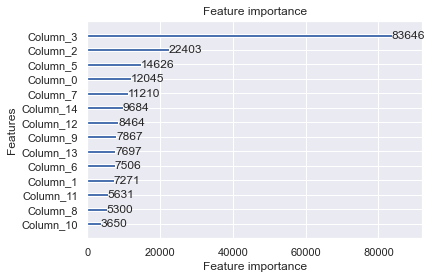

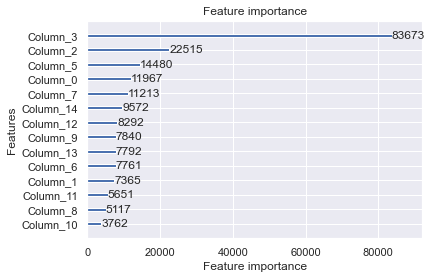

In [43]:
ft = features_importance(lgb, X_train_t.columns, y_train_t.columns)
ft_sorted = ft.iloc[(-ft['SiteEUIWN(kBtu/sf)'].abs()).argsort()]
ft_sorted.head(30)

####  SOTA 
-------------------------------------
    LightGBM:
    
    'estimator__boosting': 'dart',
    'estimator__num_leaves': 70,
    'estimator__max_depth': 15,
    'estimator__min_child_samples': 5,
    'estimator__colsample_bytree': 0.8550253325940058,
    'estimator__subsample': 0.9990544403425882,
    'estimator__subsample_freq': 2,
    'estimator__lambda_l2': 0.01,
    'estimator__learning_rate': 0.02, 
    'estimator__n_estimators': 5000
    
    performance: onehot encoding
    
     'r2_train: ': 0.9884079706083344,
     'r2_trainCV': None,
     'r2_test': 0.885387892066807,
     'mse_test': 1168.4676071705665
    xgboost:
    
    'multioutputregressor__estimator__colsample_bytree': 0.8,
    'multioutputregressor__estimator__gamma': 0.1,
    'multioutputregressor__estimator__learning_rate': 0.1,
    'multioutputregressor__estimator__max_depth': 50,
    'multioutputregressor__estimator__n_estimators': 200,
    'multioutputregressor__estimator__subsample': 0.8},
    
    performance: onehot encoding
    
    'r2_train: ': 0.9999809031090972,
    'r2_trainCV': None,
    'r2_test': 0.8991338963522097,
    'mse_test': 1041.7457986265968,
-----------------------------------